### Installing Packages

Research Paper written on the dataset and problem: https://www.researchgate.net/publication/220320916_Causality_Challenge_Benchmarking_relevant_signal_components_for_effective_monitoring_and_process_control

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
!pip install ucimlrepo
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import IsolationForest

## Introduction to a Data Science Project on the UCI ML Repository SECOM Dataset

**Dataset Overview:**

This project centers around the analysis of the SECOM dataset, a substantial and detailed collection of data from a semiconductor manufacturing process.

**The first file** contains 1567 rows, with 591 features. These features represent various measurements and sensor readings captured during the manufacturing process.

**The second file** consists of corresponding labels for each row, providing a pass/fail classification along with a date-time stamp that marks the point of each test within the manufacturing cycle.

**Data Characteristics:**

Reflecting real-world data conditions, the SECOM dataset authors alert the Data Scientist embarking on this project of the presence of null values, with the intensity of these missing values varying across different features. This aspect of the dataset is a common challenge in data analysis and will be addressed through thoughtful pre-processing techniques.


**Project Objective:**

The primary goal of this machine learning project is to uncover and understand the most predictive features that influence the pass/fail outcomes of the semiconductor manufacturing process.

The stakeholder has requested us to identify a subset of features that hold the most significant predictive power, and explore the causal relationships among these key features and how they impact the overall pass/fail rates, providing insights that could be vital for process improvement and quality control.

### Importing Data from UCI

In [2]:
def uci_data_request(train_url,labels_url):

  # Downloading the training data
  response = requests.get(train_url)
  data = pd.read_csv(BytesIO(response.content), sep=" ", header=None)

  # Downloading the labels data
  response = requests.get(labels_url)
  labels_data = pd.read_csv(BytesIO(response.content), sep=" ", header=None)

  df = pd.merge(data, labels_data,left_index=True, right_index=True,how='inner')
  df.rename(columns={'0_x':'0','1_x':'1','0_y':'Pass/Fail','1_y':'Time'}, inplace = True)

  return df

In [3]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [4]:
df = uci_data_request(train_url,labels_url)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,582,583,584,585,586,587,588,589,Pass/Fail,Time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 15:22:00


### Exploratory Data Analysis


**Initial Thoughts:**
We know that the target variable represents a simple pass/fail classification corresponding to each row in the dataset, where –1 corresponds to a pass and 1 corresponds to a fail. In additiona, a date-time stamp for each pass/fail is provided in the labels file corresponding to a selected functionality test. This begs the question if the data should be treated as time series, or not. To understand if that is the case we will need to check if the dataset preserves a temporal order, and is free of irregularities

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, 0 to Time
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


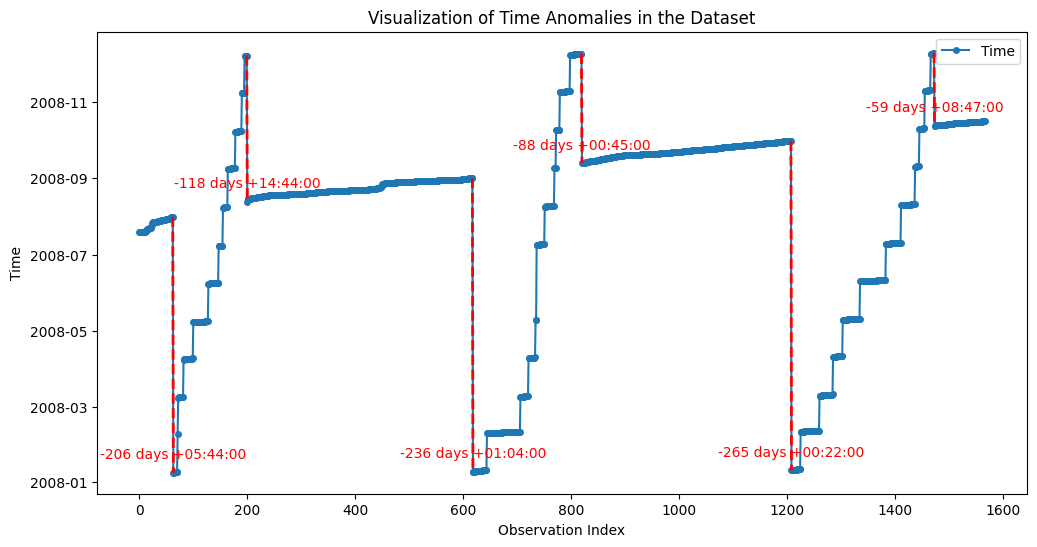

In [6]:
#Checking if there are any chronological violations in the timestamps

import matplotlib.pyplot as plt

df['Time'] = pd.to_datetime(df['Time'])

# Create a lagged 'Time' column
df['Time_lag_1'] = df['Time'].shift(1)


# Calculate the differences and find backward jumps
df['Time_Difference'] = df['Time'] - df['Time_lag_1']
backward_jumps = df[df['Time_Difference'] < pd.Timedelta(0)]

# Plot the 'Time' against their index
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Time'], label='Time', marker='o', linestyle='-', markersize=4)

# Loop through the backward jumps and annotate them
for jump_index in backward_jumps.index:
    time_difference = backward_jumps.loc[jump_index, 'Time_Difference']
    plt.plot([jump_index-1, jump_index], [df.loc[jump_index-1, 'Time'], df.loc[jump_index, 'Time']],
             color='red', linestyle='--', linewidth=2)  # Highlight the jump with a red dashed line
    plt.annotate(f'{time_difference}',
                 xy=(jump_index, df.loc[jump_index, 'Time']),
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.xlabel('Observation Index')
plt.ylabel('Time')
plt.title('Visualization of Time Anomalies in the Dataset')
plt.legend()
plt.show()


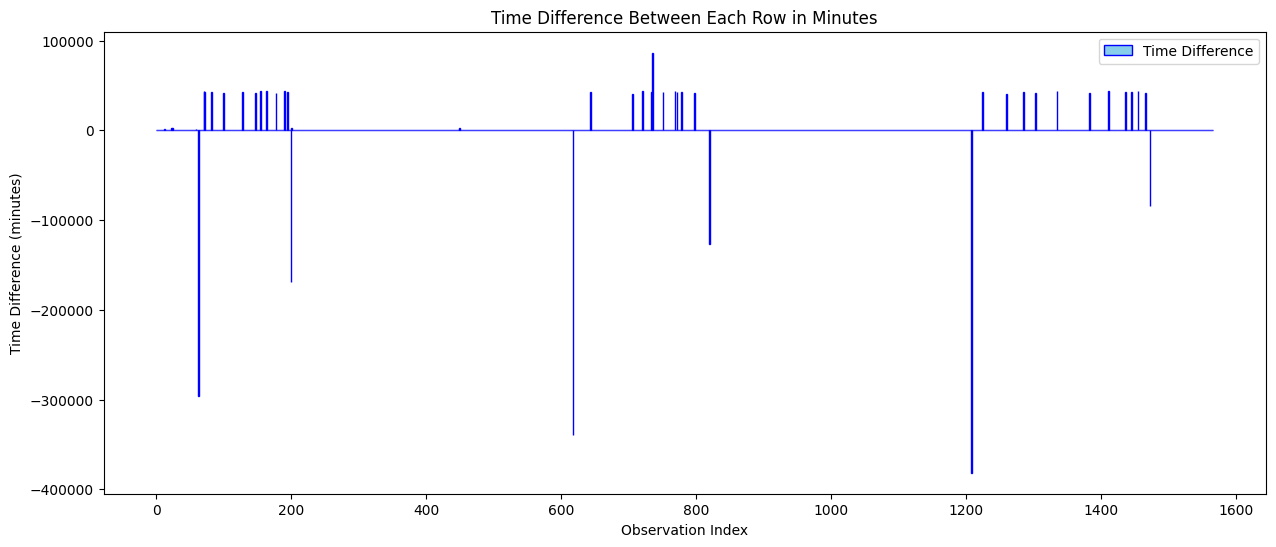

In [7]:
# Checking to see if the temporal difference between each run is consistent

df['Time_Difference_Minutes'] = df['Time_Difference'].dt.total_seconds() / 60

# Create a more pronounced bar plot of the time differences in minutes
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
# Set a larger width for the bars to make them more pronounced
plt.bar(df.index, df['Time_Difference_Minutes'], label='Time Difference', width=1.0, color='skyblue', edgecolor='blue')

plt.xlabel('Observation Index')
plt.ylabel('Time Difference (minutes)')
plt.title('Time Difference Between Each Row in Minutes')
plt.legend()
plt.show()



### Argument for Cross-Sectional Analysis Given Temporal Discrepancies and Dataset Characteristics

#### **Graph Observations**

**Temporal Irregularities and Discrepancies:**

Our initial EDA has revealed notable irregularities in the temporal order of the dataset, including instances of "going back in time." Such discrepancies make a time-series analysis, which assumes a logical and consistent temporal sequence, impractical and potentially misleading. Furthermore, the spacing between timestamps varies significantly, ranging from minutes to several days. This irregularity introduces substantial challenges in establishing any meaningful time-based patterns or dependencies, as traditional time-series methods rely on consistent time intervals for analysis.

**Independence of Manufacturing Runs:**

Given these temporal inconsistencies, it is more logical to treat each manufacturing run as an independent event. This approach allows for an analysis focused on the conditions and sensor readings at the time of each test, without the confounding influence of erratic time gaps.

**Operational Realities of the Manufacturing Process:**

Another consideration is the nature of the manufacturing process, potentially involving recalibrations and changes in setup between each run. This supports the notion that each run should be evaluated on its own merits. Also, the temporal discrepancies suggest that the state of the process at one point may not reliably inform the state at another.

**Methodological Fit and Practicality:**

A cross-sectional approach is methodologically suitable under these conditions. As we are not interested in the change of features over time, but only their performance a single point in time. The approach enables the application of various statistical and machine learning techniques to identify key predictive features for pass/fail outcomes without the need for temporal modeling.

In [8]:
#Dropping time related columns
df.drop(columns = ['Time_Difference','Time_Difference_Minutes','Time','Time_lag_1'], inplace=True)

In [9]:
#Changing all column names to string format for consistency
def column_names(df):
  for col in df.columns:
    df.rename(columns = {col:f'{col}'}, inplace=True)

In [10]:
column_names(df=df)

In [11]:
#Various data types
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [12]:
#Initial look at the data
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


#### Identifying & Removing Constant Features

In [13]:
def constant_features(df): #Checking if we have more then one constant column
  df_constant_col = [col for col in df.columns if df[col].std() == 0]
  return df[df_constant_col]

In [14]:
constant_columns = constant_features(df)
constant_columns

,5,13,42,49,52,69,97,141,149,178,...,529,530,531,532,533,534,535,536,537,538
0,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1563,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,100.0,NaN,70.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,100.0,0.0,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


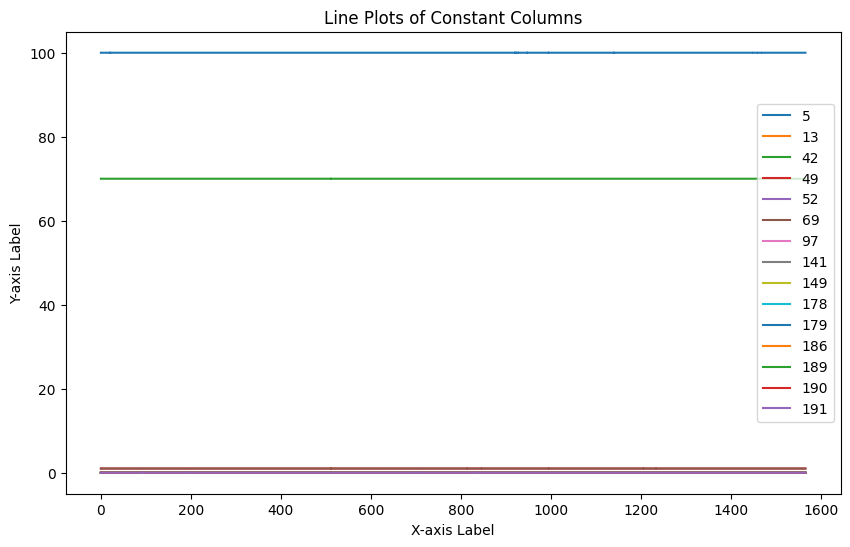

In [15]:
#Plotting a few of the constant features to assess their characteristics

columns_to_plot = constant_columns.columns[0:15]

# Create a plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed

for col in columns_to_plot:
    constant_columns[col].plot(label=col)

plt.xlabel('X-axis Label')  # Replace with your x-axis label
plt.ylabel('Y-axis Label')  # Replace with your y-axis label
plt.title('Line Plots of Constant Columns')
plt.legend()  # This adds a legend, which is crucial for multiple lines

plt.show()


**Observation:**
The majority of contant features have values around 0. However, there are exceptions with larger values. This could indicate that some of these sensors are monitoring stability, and if there are deviations the numbers might change.

**Column Removal Decision:**

In line with the guidance from the SECOM dataset authors, we have decided to drop the columns that are constant, due to insufficient information about their significance. This action results in the removal of 116 columns from the dataset.

**Rationale Against Splitting Before Dropping:**

An alternative approach might have involved splitting the DataFrame into training and test sets prior to dropping these columns. However, this was deemed inappropriate because it could lead to inconsistencies. For instance, in an 80-20 train-test split, one subset might end up with constant values in a significant proportion of its columns (either 80% or 20%), leading to a mismatch in columns between the training and test sets. Such disparities can adversely affect model training and validation, thereby undermining the reliability of the analysis.

In [16]:
df.drop(columns = constant_columns.columns, inplace=True) #Dropping constant columns

In [17]:
df.head()

,0,1,2,3,4,6,7,8,9,10,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


#### Target Variable - Converting to categorical

In [18]:
df['Pass/Fail'] = df['Pass/Fail'].replace(to_replace=-1,value=0) #Out of personal preference "0" now represents pass and "1" fail

In [19]:
df['Pass/Fail'].astype('category')

0       0
1       0
2       1
3       0
4       0
       ..
1562    0
1563    0
1564    0
1565    0
1566    0
Name: Pass/Fail, Length: 1567, dtype: category
Categories (2, int64): [0, 1]

#### Correlation Matrix

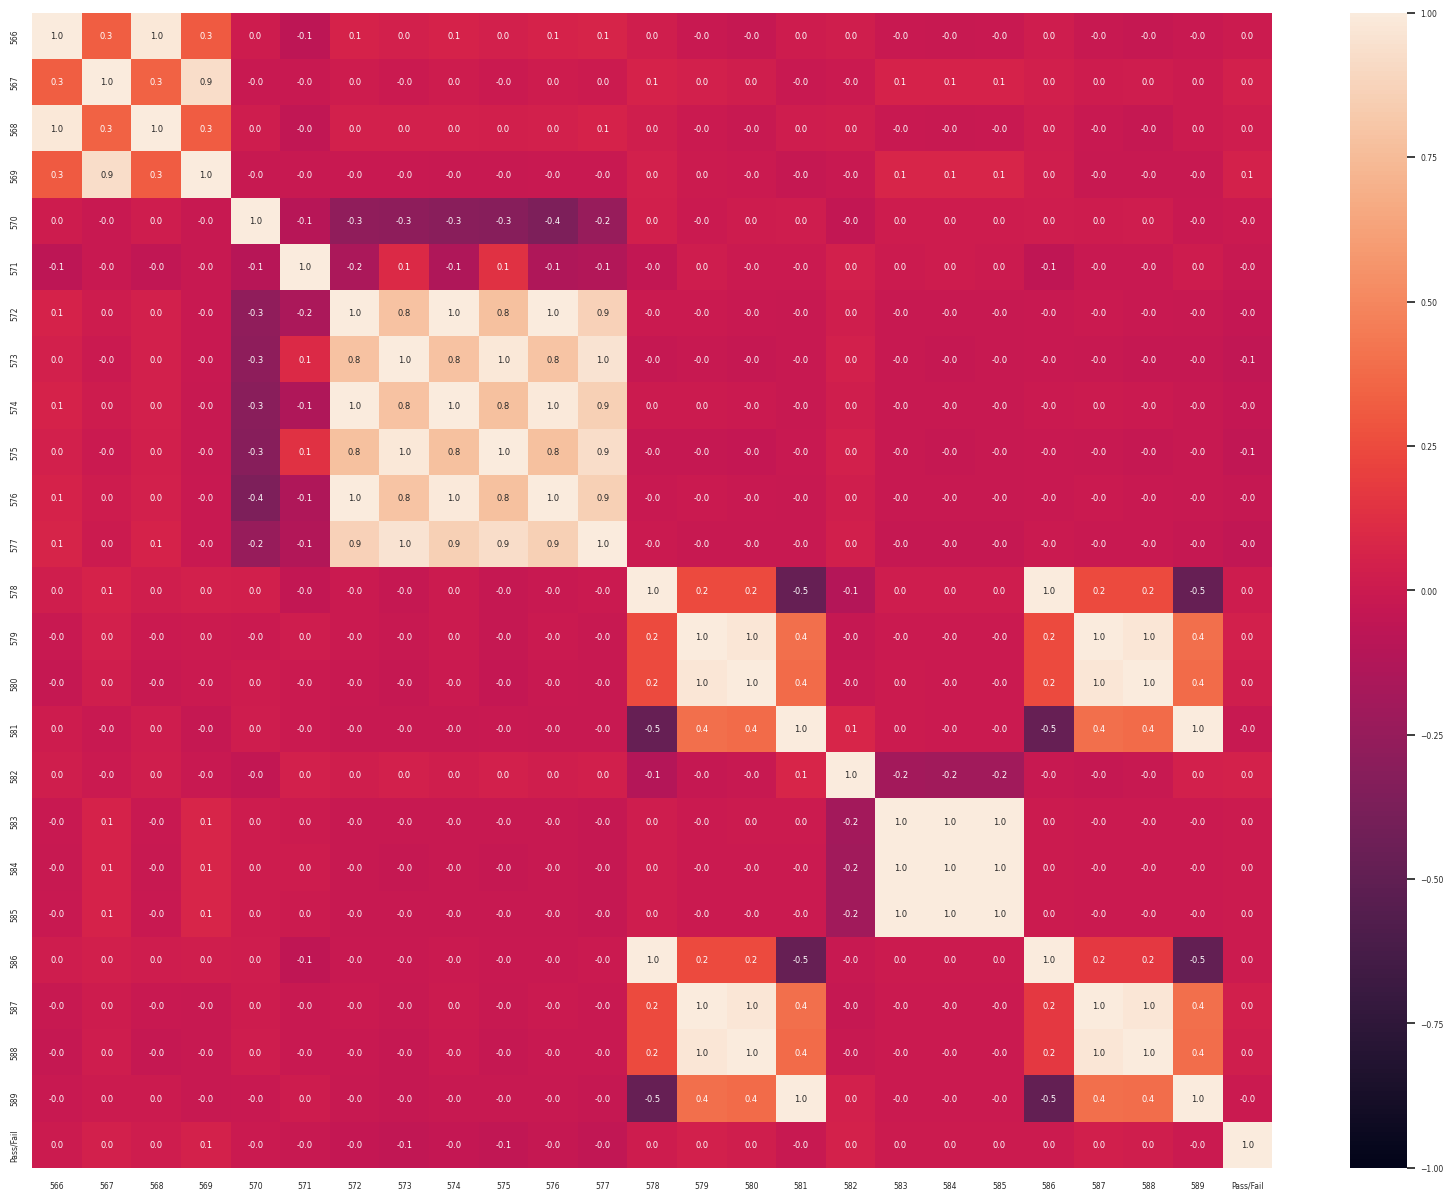

In [ ]:
#Correlation Matrix

# Increase figure size
plt.figure(figsize=(20, 15))

# Reduce font size for annotations if necessary
sns.set(font_scale=0.5)

# Create the heatmap
heatmap = sns.heatmap(df.iloc[:, 450:].corr(), vmin=-1, vmax=1, annot=True, fmt=".1f")

# Show the plot
plt.show()


**Observation:** We can clearly see that some features are perfectly correlated with each other, which could indicate high multicolinearity. However, we proceed with the EDA, and will make a decision later on what to do with multicolinearity.

#### Checking for Null Columns


In [20]:
null_features = [col for col in df.columns if df[col].isnull().sum()/len(df)>0.1]
df[null_features]

,72,73,85,109,110,111,112,157,158,220,...,564,565,566,567,568,569,578,579,580,581
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0096,0.0201,0.0060,208.2045
2,140.6972,485.2665,NaN,NaN,NaN,NaN,0.4684,NaN,NaN,NaN,...,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,0.0584,0.0484,0.0148,82.8602
3,160.3210,464.9735,NaN,NaN,NaN,NaN,0.4647,NaN,NaN,NaN,...,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,0.0202,0.0149,0.0044,73.8432
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,NaN,NaN,NaN,0.9833,102.0542,231.1404,NaN,NaN,NaN,NaN,...,4.98,0.0877,2.0902,0.0382,1.8844,15.4662,0.0068,0.0138,0.0047,203.1720
1563,158.7832,463.3486,NaN,0.9824,97.5426,235.2582,NaN,NaN,NaN,NaN,...,4.56,0.1308,1.7420,0.0495,1.7089,20.9118,NaN,NaN,NaN,NaN
1564,NaN,NaN,0.1119,0.9839,101.4167,231.2249,NaN,NaN,NaN,0.0089,...,11.09,0.2388,4.4128,0.0965,4.3197,29.0954,0.0197,0.0086,0.0025,43.5231
1565,NaN,NaN,NaN,0.9828,101.3445,233.0335,NaN,NaN,NaN,NaN,...,4.98,0.0877,2.0902,0.0382,1.8844,15.4662,0.0262,0.0245,0.0075,93.4941


**Observation:** There's a significant amount null values in the data set. According to the SECOM dataset authors null values correspond to no recorded measurement for a particular feature.

In [21]:
def null_val(df, threshold):
  null_columns = [col for col in df.columns if df[col].isnull().sum()/len(df[col]) > threshold]
  return df.drop(columns = null_columns)

In [22]:
df = null_val(df=df,threshold=0.1) #can be tuned


**Why are we dropping null values before Train, test, split?**

Dropping columns based on a threshold of null values before the train-test split is generally a good practice for the following reasons:

Consistency Across Datasets: By dropping columns before the split, you ensure that both the training and test datasets have the same set of features. This consistency is crucial because a model trained on a certain set of features expects the same features during testing and in production.

Avoiding Data Leakage: If you drop columns based on the null value threshold after splitting into training and test sets, there's a risk of introducing bias. For instance, if a column is dropped in the training set but not in the test set (or vice versa) due to different proportions of missing values, this can lead to discrepancies and potential data leakage.



In [23]:
df_nulls = [col for col in df.columns if df[col].isnull().sum()>0]

In [24]:
df[df_nulls].isnull().sum().max() #Reduced to a maximum of 40 rows

51

In [25]:
df[df_nulls].isnull().sum().max()/len(df)*100 #Column with Max percent of nulls

3.2546266751754946

<Axes: >

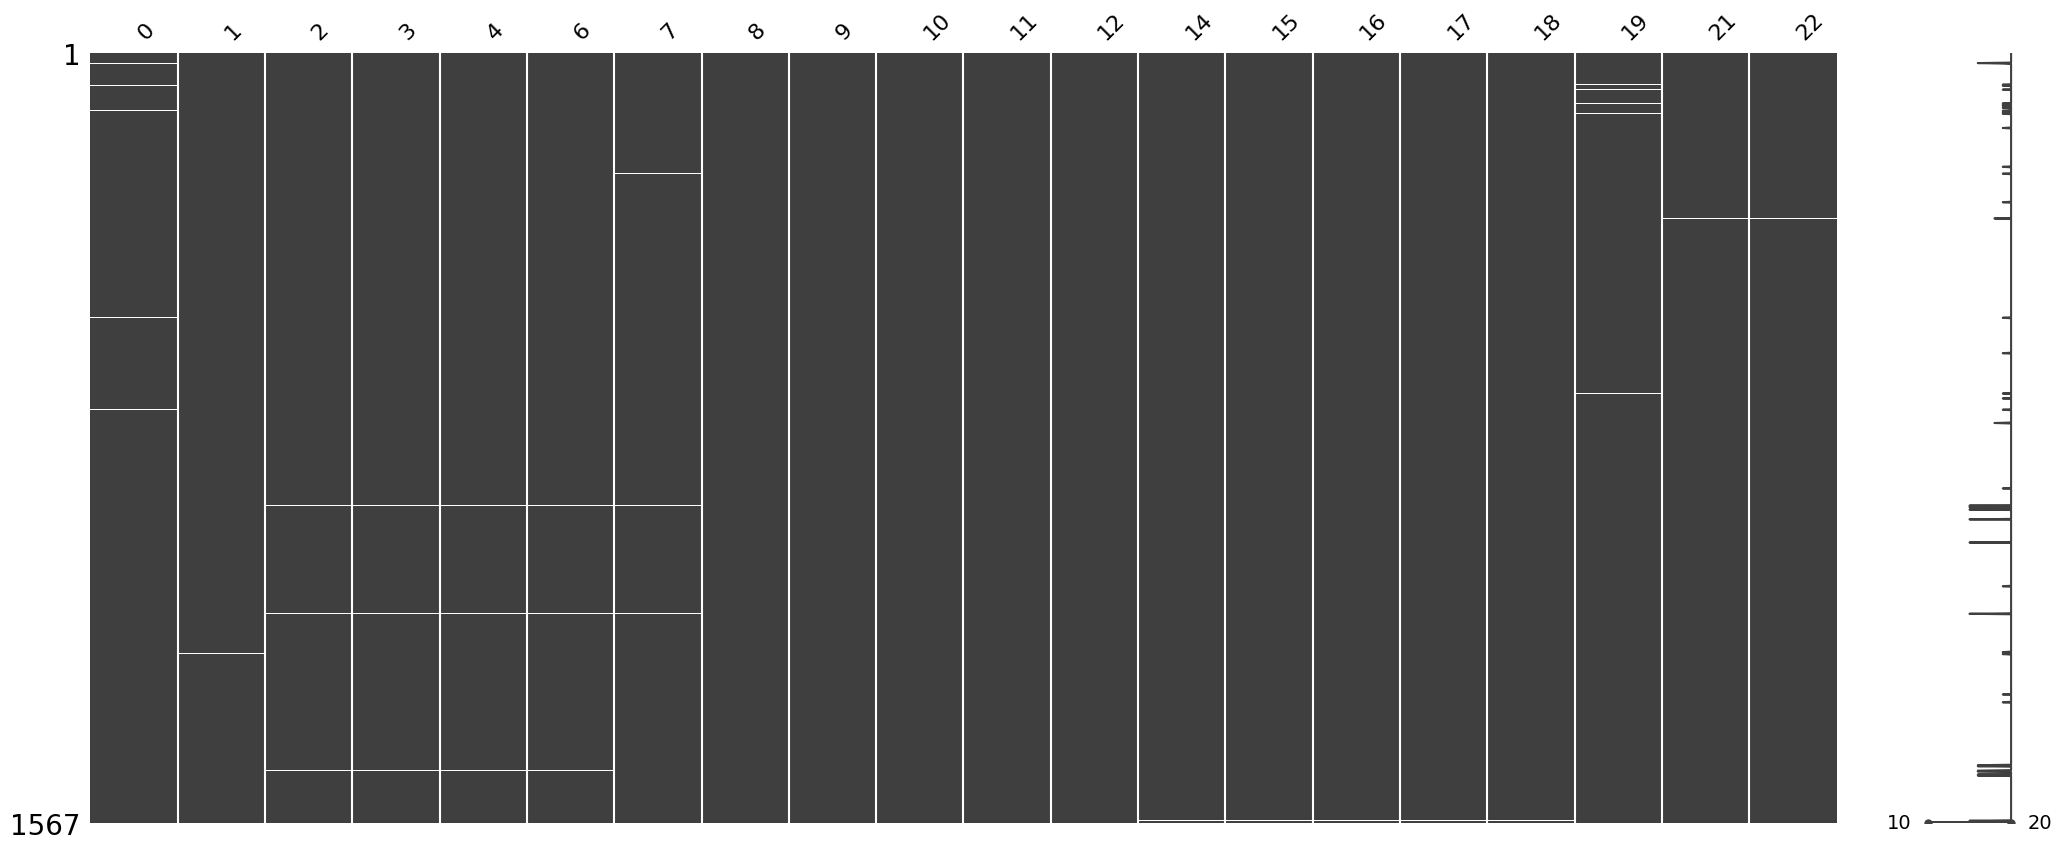

In [26]:
msno.matrix(df[df_nulls[0:20]])

**Null patterns:** There appears to be some pattern between sensor feature nulls. However, a null analysis is beyond the scope of this ML project.

#### Splitting the Dataframe into training and testing sets

In [284]:
X = df.drop(['Pass/Fail'], axis=1)
y = df['Pass/Fail']


#Stratify = y as this is a classification problem
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 55, shuffle = True)

**Objective:** To prevent data leakage we split the DataFrame into training and testing set before further data manipulation.

##### Imputing Null Values

In [28]:
def mean_values(df):
  means = {}
  for col in df.columns:
    means[col] = df[col].mean()
  return means

def null_imputer(df, means):
    columns = df.columns
    df_imputed = df.copy()
    for col in columns:
        df_imputed[col].fillna(value=means[col], inplace=True)

    return df_imputed

In [29]:
X_train_1 = X_train.copy()
train_mean = mean_values(X_train_1)

In [30]:
X_train_1 = null_imputer(X_train_1,means=train_mean)

We decide to impute the remaining null values by its column mean. This is a straightforward approach, but other methods could be evaluated in accordance with in-sample metrics.

#### Checking for Outliers

In [35]:
#Traditional Z-score approach
#Find the index with outliers per column, and get a count

def identify_outliers(df):
    outlier_indices = []  # List to hold indices of outliers

    # Iterate over each column
    for col in df.columns:
        if df[col].dtype.kind in 'bifc':  # Check if the column is numeric
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Find the indices of outliers in the current column and extend the list
            column_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(column_outliers)

    # Identify unique indices since a row can be an outlier in more than one column
    outlier_indices = list(set(outlier_indices))

    # Return DataFrame of outliers
    return df.loc[outlier_indices]

# Apply the function to your DataFrame
outlier_rows = identify_outliers(X_train_1)


In [39]:
outlier_rows #Tells us that each row contains at least one outlier in the data set across our features

,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.496600,-0.000500,-0.014800,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.443600,0.004100,0.001300,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.488200,-0.012400,-0.003300,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
5,2946.25,2432.84,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.528700,0.016700,0.005500,...,1.6679,13.7755,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077
6,3030.27,2430.12,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.581600,-0.027000,0.010500,...,1.1958,8.3645,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,2951.14,2326.59,2212.6334,1081.5662,1.0096,113.4278,0.1253,1.449200,-0.013400,0.012700,...,1.8354,15.6350,0.4965,0.0118,0.0032,2.3817,0.0320,0.0148,0.0051,46.4573
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,82.2467,0.1248,1.342400,-0.004500,-0.005700,...,1.4879,11.7256,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,98.4689,0.1205,1.433300,-0.006100,-0.009300,...,1.0187,17.8379,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,99.4122,0.1208,1.463208,-0.000609,0.000152,...,1.2237,17.7267,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231


In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_outlier_count_bins_with_percentage(df, bins=10):
    outlier_counts = []  # List to store count of outliers for each column

    # Iterate over each column
    for col in df.columns:
        if df[col].dtype.kind in 'bifc':  # Check if the column is numeric
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers in the current column and add to list
            count_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
            outlier_counts.append(count_outliers)

    counts_array = np.array(outlier_counts)  # Convert to numpy array for easy binning
    total_columns = len(outlier_counts)  # Total number of columns considered

    # Determine the bin edges for dividing outlier counts
    max_count = counts_array.max()
    bins = np.linspace(0, max_count, bins + 1)  # Create evenly spaced bins

    # Plotting
    plt.figure(figsize=(10, 6))
    counts, edges, patches = plt.hist(counts_array, bins=bins, color='skyblue', edgecolor='black')

    # Calculate and annotate percentage for each bin
    for count, edge, patch in zip(counts, edges, patches):
        height = patch.get_height()
        percent = 100 * (count / total_columns)
        plt.text(edge + patch.get_width() / 2, height + 0.5, f'{percent:.1f}%', ha='center')

    plt.xlabel('Outlier Count Range')
    plt.ylabel('Number of Columns')
    plt.title('Distribution of Outlier Counts Across Columns (%)')
    plt.xticks(bins)
    plt.show()



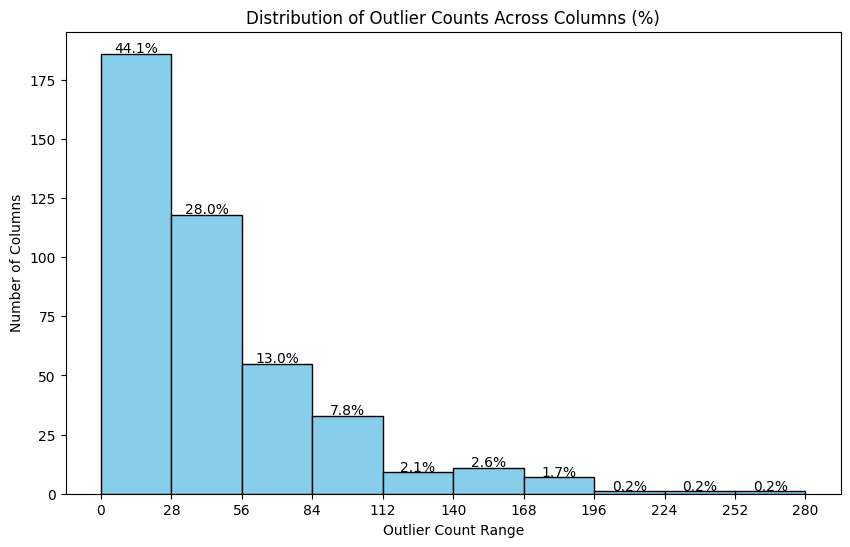

In [47]:
plot_outlier_count_bins_with_percentage(X_train_1, bins=10)

In [79]:
y_train_out = y_train.copy()

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution_in_outlier_bins(df, labels, bins=10, outlier_threshold=112):
    outlier_counts = {}

    # Calculate the count of outliers in each column and map to column names
    for col in df.columns:
        if df[col].dtype.kind in 'bifc':  # Check if the column is numeric
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            count_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
            if count_outliers > 0:
                outlier_counts[col] = count_outliers

    outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Count'])
    max_count = outlier_counts_df['Count'].max()
    bin_edges = np.linspace(0, max(max_count, outlier_threshold), bins + 1)
    outlier_counts_df['Bin'] = pd.cut(outlier_counts_df['Count'], bin_edges, include_lowest=True, labels=range(bins))

    # Calculate class distribution for each bin
    bin_class_distributions = {bin_label: [] for bin_label in range(bins)}
    for bin_label in range(bins):
        columns_in_bin = outlier_counts_df[outlier_counts_df['Bin'] == bin_label]['Column']
        outlier_indices = set()
        for col_name in columns_in_bin:
            Q1 = df[col_name].quantile(0.25)
            Q3 = df[col_name].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)].index
            outlier_indices.update(outliers)

        if outlier_indices:
            class_distribution = labels.loc[list(outlier_indices)].value_counts(normalize=True) * 100
            for class_label in class_distribution.index:
                bin_class_distributions[bin_label].append(class_distribution[class_label])
        else:
            bin_class_distributions[bin_label] = [0, 0]  # No outliers found for this bin

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    # Generate bin labels showing the range of outlier counts
    bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges)-1)]

    class_0_percentages = [dist[0] if dist else 0 for dist in bin_class_distributions.values()]
    class_1_percentages = [dist[1] if len(dist) > 1 else 0 for dist in bin_class_distributions.values()]

    ax.bar(bin_labels, class_0_percentages, label='Class 0', alpha=0.6)
    ax.bar(bin_labels, class_1_percentages, bottom=class_0_percentages, label='Class 1', alpha=0.6)

    ax.set_xlabel('Outlier Count Range')
    ax.set_ylabel('Percentage of Class Distribution')
    ax.set_title('Class Distribution Across Different Bins of Outlier Counts')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


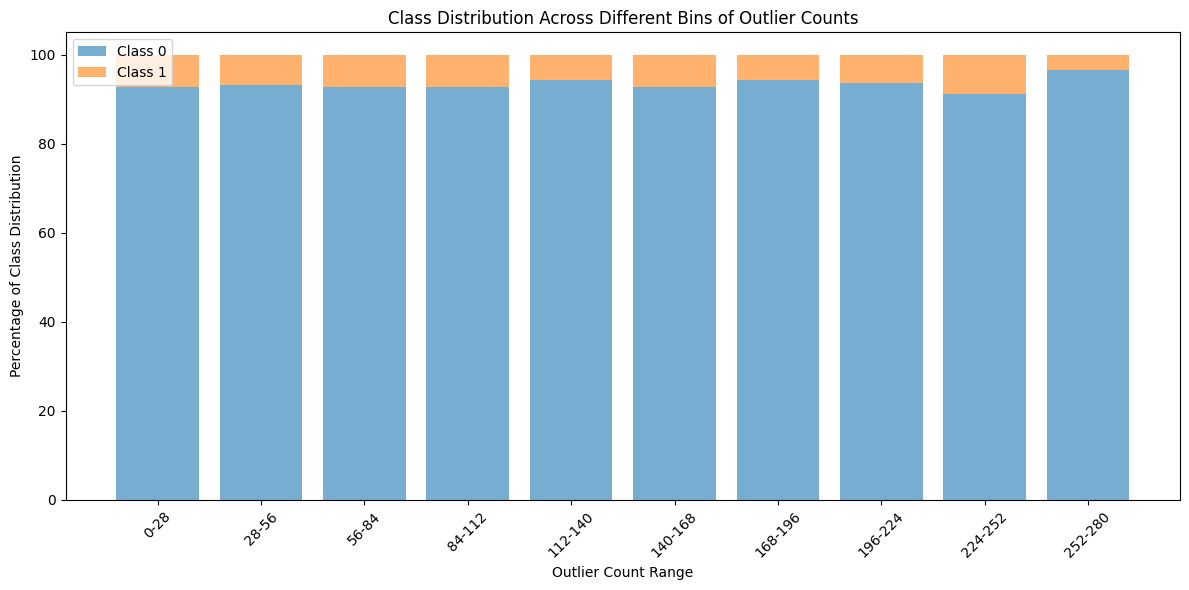

In [81]:
plot_class_distribution_in_outlier_bins(X_train_1, y_train_out, bins=10)

Class Distribution Consistency: The lack of significant variance in class distribution across bins suggests that outliers, as defined in this context, may not be a strong indicator of class membership. This might imply that outlier-based feature engineering might not necessarily improve model performance for class prediction.

Model Selection: Given the distribution of outliers, you may not need to prioritize outlier-robust models. However, it's still important to validate this with actual modeling and cross-validation to see if models sensitive to outliers (like linear models with least squares fitting) perform poorly compared to more robust models (like tree-based models).

Conclusion: We are going to explore models with both outliers included and outlier imputation methods.

#### PCA EDA

In [92]:
#PCA with outliers imputed and PCA without outliers imputed
def detect_outliers(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (series < lower_bound) | (series > upper_bound)

def apply_winsorization(X_train):
  X_train = X_train.copy()
  columns = X_train.columns
  for col in columns:
    condition = detect_outliers(X_train[col])
    winsorization = winsorize(X_train[col], limits=[0.05, 0.05])
    X_train[col] = np.where(condition, winsorization, X_train[col])
  return X_train


def apply_outlier_imputation(X_train):
  X_train = X_train.copy()
  columns = X_train.columns

  for col in columns:
    condition = detect_outliers(X_train[col])
    median_value = X_train[col].median()
    X_train[col] = np.where(condition, median_value, X_train[col])
  return X_train

In [93]:
#Imputing outliers by median before PCA
X_train_1_imputed = apply_outlier_imputation(X_train_1)

In [101]:
#Winsorizing Outliers
X_train_1_winsorized = apply_winsorization(X_train_1)

In [94]:
#Imputing null values with X_train column means to prevent leakage
X_test_1 = X_test.copy()
X_test_1 = null_imputer(X_test_1,means=train_mean)

In [141]:
X_train_pca = X_train_1_winsorized.copy()
# Initialize the Universal Scaler for Standardizing
standard_scaler = StandardScaler()

# Standardize the training set
X_train_standardized = pd.DataFrame(standard_scaler.fit_transform(X_train_pca), columns=X_train_pca.columns)


# Standardize the test set using the same StandardScaler as on X_train
X_test_standardized = pd.DataFrame(standard_scaler.transform(X_test_1), columns=X_test_1.columns)

#PCA Model & Features
n_components = 120
pca = PCA(n_components=n_components)
#X_train_pca = pca.fit_transform(X_train_standardized)

In [142]:
def pca_cols_name(pca_components:int):
  cols=[]
  for i in range(1,pca_components+1):
    cols.append(f'V{i}')

  return cols

In [143]:
columns = pca_cols_name(pca_components=n_components)

In [144]:
pca_loading_vectors = pd.DataFrame(pca.fit(X_train_standardized).components_.T, index=X_train_standardized.columns,
                                   columns=columns)
pca_loading_vectors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120
0,-0.014311,-0.012352,0.025266,-0.013093,0.005723,-0.014058,-0.011469,-0.014154,0.020977,0.011204,...,-0.053177,-0.061718,-0.081269,-0.044622,0.006511,0.086979,0.009549,0.149201,-0.096717,-0.045238
1,-0.000782,0.005747,0.010198,0.012079,0.005149,0.030818,-0.023935,-0.002025,-0.028619,-0.001603,...,0.003298,0.094277,0.021409,-0.159185,0.176427,-0.082092,0.050949,-0.104212,-0.033893,0.195364
2,0.009299,0.022431,0.012607,0.019854,-0.032908,-0.016870,-0.013215,0.016709,0.045531,-0.019564,...,-0.057542,-0.041310,0.021402,-0.016231,-0.111608,0.044976,0.153456,-0.058602,0.028692,-0.127409
3,-0.019583,-0.018968,0.049384,0.017259,-0.023244,-0.050883,-0.027418,0.010058,-0.004480,0.010313,...,0.021616,0.066733,-0.165217,-0.029142,0.052800,-0.059795,-0.012535,-0.057152,0.039196,-0.029025
4,-0.032792,0.005649,0.011745,0.012781,-0.033651,-0.033021,-0.003976,0.027234,-0.023623,-0.016311,...,-0.106920,-0.080529,0.073064,0.066311,-0.072311,0.155274,-0.080736,-0.007143,0.095119,0.090435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,-0.001390,0.021709,-0.021401,0.003425,-0.002533,-0.004218,0.015698,0.015469,0.019130,-0.015356,...,-0.005944,0.014334,-0.016088,-0.001512,0.006515,0.018272,0.014507,-0.030981,0.019761,0.007228
586,-0.020999,-0.012036,0.021754,-0.015970,0.021291,0.023689,-0.021762,-0.008342,-0.010845,-0.016060,...,0.065320,0.003583,-0.047138,-0.010436,-0.062677,0.022952,-0.072119,-0.055305,-0.011036,-0.029007
587,0.007735,0.021312,-0.033220,-0.007504,-0.000618,0.003084,0.007614,0.019128,0.033041,0.015939,...,0.011210,0.010826,0.009527,-0.027397,-0.039645,-0.013857,-0.072901,-0.025764,-0.002920,-0.009588
588,0.008998,0.023989,-0.030768,-0.004763,-0.003650,-0.001531,0.004006,0.012254,0.030569,0.013730,...,0.009240,0.016891,0.009823,-0.025700,-0.043912,-0.022891,-0.067057,-0.020980,-0.004598,-0.000678


In [145]:
pca.explained_variance_

array([18.81756678, 15.12949852, 13.37215787,  9.31736215,  8.92277362,
        8.01633535,  7.84803557,  7.39560835,  6.82621817,  6.69434723,
        6.36342981,  6.08992128,  5.99301114,  5.52942864,  5.39493871,
        5.31059096,  5.1567546 ,  5.0470776 ,  4.67820251,  4.52684063,
        4.50488251,  4.39608267,  4.27520891,  4.16204128,  4.11761896,
        3.96858475,  3.91475525,  3.89203282,  3.77997637,  3.71344178,
        3.60745337,  3.55373112,  3.50044334,  3.44146927,  3.34937186,
        3.27526827,  3.2232288 ,  3.17362344,  3.1651758 ,  3.11948963,
        3.05741304,  2.9933325 ,  2.96215006,  2.8697157 ,  2.85116162,
        2.81894757,  2.7658969 ,  2.73366588,  2.70586759,  2.6314564 ,
        2.62421632,  2.56197178,  2.54437619,  2.44296729,  2.43265349,
        2.3864667 ,  2.31270781,  2.27821889,  2.24914123,  2.19691573,
        2.177334  ,  2.15473403,  2.11357207,  2.08649365,  2.03932504,
        2.01329646,  1.967715  ,  1.95329312,  1.93776298,  1.90

In [146]:
#Outliers Imputed PEC
pca.explained_variance_ratio_.sum()
#Outliers Winsorized PEC


0.8879479728547579

PEC imputing outliers by median: 0.8543408479485908

PEC winsorizing outliers: 0.8880894849972736

PEC leaving outliers untouched: 0.8995918327573964

ValueError: x and y must have same first dimension, but have shapes (120,) and (130,)

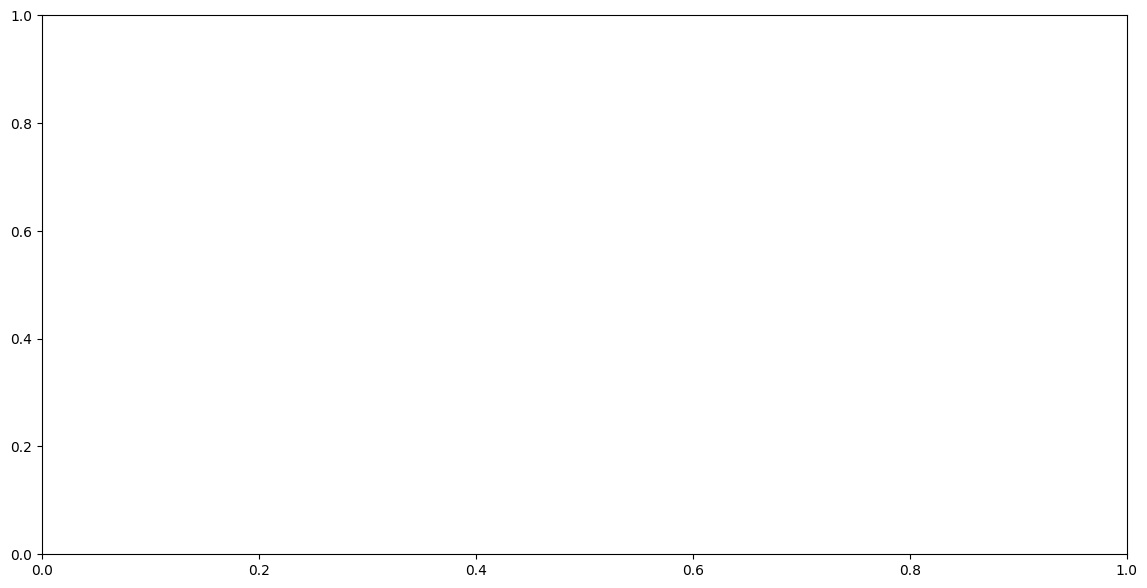

In [140]:
# Now let's create the plot as per your description
plt_numbers = list(range(1, 121))  # Generate numbers from 1 to 115

plt.figure(figsize=(14, 7))  # Set a larger figure size for better readability

# Plot the individual explained variance ratio
plt.plot(plt_numbers, pca.explained_variance_ratio_, '-o', label='Individual component')

# Plot the cumulative explained variance ratio
plt.plot(plt_numbers, np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

# Setting up the plot
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75, 115.25)  # Adjusted for the range of components
plt.ylim(-0.01, 1.05)  # Slightly adjusted to not start from below 0
plt.xticks(range(0, 121, 5))  # Adjusted to start from 0 and go till 115
plt.yticks(np.arange(0, 1.1, step=0.1))  # Steps of 0.1 for y-axis
plt.legend(loc='upper left')
plt.title('Variance Explained by PCA Components')
plt.grid(True)  # Add grid for better readability
plt.show()


In our PCA analysis, we observed varying degrees of explained variance based on our treatment of outliers. Notably, the method leaving outliers untouched yielded a PEC of approximately 90% with fewer principal components, suggesting that outliers may be integral to the underlying data structure and carry valuable information.

In this context, the relatively high PEC when outliers are left in the dataset, as opposed to 85.4% with median imputation and 88.8% with winsorization — may indicate that outliers are contributing to this spread of informative variance. It hints that the data contains complex, multi-dimensional patterns where outliers play a significant role, and their removal or alteration dilutes these nuanced patterns.

Our correlation matrix findings fortify this argument; the absence of strong individual correlations implies that the predictive signal is not dominated by any subset of features but rather distributed across the dataset. It is this complexity and lack of dominant features that likely drive the need for a greater number of PCs to achieve a satisfactory level of explained variance. This characteristic of the data will be crucial to consider in downstream tasks, as models that can navigate such multi-dimensional spaces without overfitting will be essential for robust predictions.


The next phase of our investigation will pivot toward practical application: we'll deploy the principal components derived from each outlier treatment strategy within cross-validation frameworks of predictive modeling tasks. This will not only gauge the performance impact of each method but also the interpretability and robustness of the PCA transformation in real-world scenarios. Such an empirical approach will ensure that the inclusion of outliers in our PCA model contributes to predictive power and not just to variance, guiding us toward a more informed and strategic handling of outliers in our dataset.

However, before we proceed with a practical applications we need to address the class imbalance in our data set.

#### Target Variable - Class Imbalance

In [147]:
y_train_1 = y_train.copy()
y_train_1 = pd.DataFrame(y_train_1)

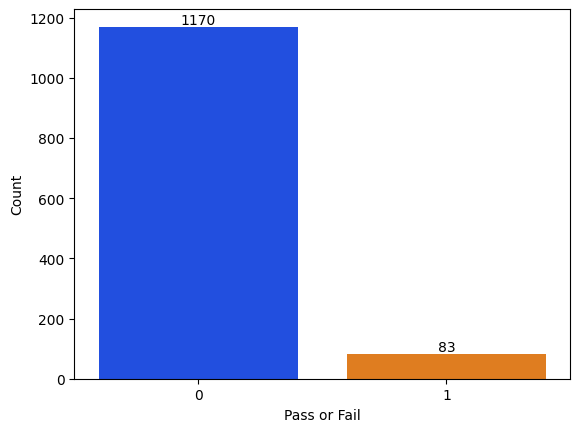

In [148]:
#Checking distribution of 0's & 1's
sns.countplot(x=y_train_1['Pass/Fail'], palette='bright', hue = y_train_1['Pass/Fail'], legend=False)
plt.xlabel('Pass or Fail')
plt.ylabel('Count')

for i in range(len(y_train_1['Pass/Fail'].value_counts())):
    count = y_train_1['Pass/Fail'].value_counts().values[i]
    plt.text(i, count+10, str(count), ha='center')

In [149]:
df['Pass/Fail'].value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

It's apparent that our data set is highly imbalanced with 1464 "pass" instances and only "104" fail instances. To treat the class imbalance we proceed with the SMOTE algorithm.

##### Treating Class Imbalance
SMOTE

In [150]:
def class_imb_technique(X, y, scaler_choice):

  X_scaled = scaler_choice.fit_transform(X)

  # Apply SMOTE to the scaled training data
  sm = SMOTE(random_state=101, k_neighbors=5)
  X_res, y_res = sm.fit_resample(X_scaled, y)
  X_res = pd.DataFrame(X_res, columns=X.columns)
  return X_res, y_res


In [151]:
# Usage
X_train_smote = X_train_1.copy()
X_train_smote, y_train_1 = class_imb_technique(X=X_train_smote, y=y_train_1, scaler_choice=StandardScaler())

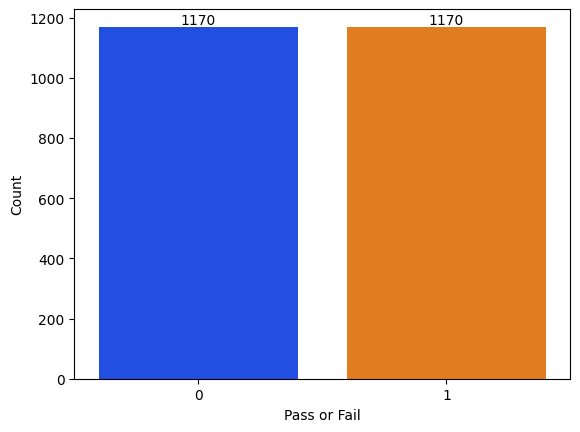

In [152]:
#Checking distribution of 0's & 1's
sns.countplot(x=y_train_1['Pass/Fail'], palette='bright', hue = y_train_1['Pass/Fail'], legend=False)
plt.xlabel('Pass or Fail')
plt.ylabel('Count')

for i in range(len(y_train_1['Pass/Fail'].value_counts())):
    count = y_train_1['Pass/Fail'].value_counts().values[i]
    plt.text(i, count+10, str(count), ha='center')

In [153]:
X_train_smote.shape, y_train_1.shape

((2340, 422), (2340, 1))

This marks the end of our EDA, and now we will proceed with discussing the appropriate evaluation metric, cross-validation with hyperparameter tuning and lastly prediction on the test set.

### What Metric Should we use to evaluate our ML models?


In semiconductor manufacturing, the choice of evaluation metric is critical to prevent the dire consequences of faulty chips. Recall outshines accuracy as the preferred metric for the following reasons:

1. **Defect Detection Priority:**
   - Faulty chips can disrupt crucial industries. Recall minimizes false negatives, enhancing the identification of defective chips during production and reducing the risk of faulty semiconductors in the market.

2. **Impact Mitigation on Industries:**
   - Maximized recall safeguards industries like automotive and healthcare by removing defective chips before reaching end-users, averting disruptions and ensuring the reliability of critical technologies.

3. **Consumer Safety Assurance:**
   - Electronic devices, vital for safety-critical systems, must be reliable. Emphasizing recall aids early issue detection, contributing to the production of safe electronic components for consumers.

4. **Preservation of Reputation:**
   - In the competitive semiconductor industry, a higher recall preserves a manufacturer's reputation by minimizing defective products, building trust, and maintaining brand integrity.

5. **Regulatory Adherence:**
   - Complying with industry standards is imperative. Prioritizing recall aligns with regulatory requirements, showcasing a commitment to quality control and adherence to standards, avoiding legal consequences.

In summary, selecting recall as the primary metric in semiconductor manufacturing is justified by its ability to enhance defect detection, mitigate industry disruptions, assure consumer safety, preserve reputation, and align with regulatory standards. This choice effectively addresses both industry and societal concerns.

To maximize recall we will be exploring several models, and we will now begin the cross-validation process to maximize our training data, and test on the validation set.

### Cross-Validation using a Pipeline

In [285]:
def custom_cross_val(X_train, y_train):

    shallow_models = [
        KNeighborsClassifier(),
        # SVC(),
        # GradientBoostingClassifier(),
        # XGBClassifier()
    ]


    feature_selection_methods = {
        'PCA': PCA(n_components=120)
    }
    results_list = []

    for method_name, feature_selector in feature_selection_methods.items():
        for model in shallow_models:
            # Define parameter distributions based on the model
            param_distributions = {}

            if isinstance(model, KNeighborsClassifier):
                param_distributions = {
                    'classifier__n_neighbors': list(range(20, 30)),
                    'classifier__weights': ['uniform', 'distance'],
                    'classifier__algorithm': ['auto', 'kd_tree'],
                    'classifier__p': [1, 2]
                }

            elif isinstance(model, SVC):
                param_distributions = {
                    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'classifier__C': [0.1, 1, 10],
                    'classifier__gamma': ['scale', 'auto']
                }


            elif isinstance(model, GradientBoostingClassifier):
                param_distributions = {
                      'classifier__n_estimators': [50, 100, 200],
                      'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                      'classifier__max_depth': [3, 4, 5],
                      'classifier__min_samples_split': [2, 5, 10],
                      'classifier__min_samples_leaf': [1, 2, 4],
                      'classifier__subsample': [0.8, 0.9, 1.0]
                  }
            elif isinstance(model, XGBClassifier):
                param_distributions = {
                      'classifier__n_estimators': [50, 100, 200],
                      'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                      'classifier__max_depth': [3, 4, 5],
                      'classifier__min_child_weight': [1, 2, 3],
                      'classifier__subsample': [0.8, 0.9, 1.0],
                      'classifier__gamma': [0, 1, 2],
                      'classifier__colsample_bytree': [0.8, 0.9, 1.0]
                  }



            n_neighbors_list = []  # Track 'n_neighbors' for KNeighborsClassifier

            random_search = RandomizedSearchCV(
                estimator=ImbPipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler()),
                    ('feature_selector', feature_selector),
                    ('smote', SMOTE(random_state=101)),
                    ('classifier', model)
                ]),
                param_distributions=param_distributions,
                n_iter=5,
                cv=StratifiedKFold(5, shuffle=True, random_state=101),
                verbose=2,
                random_state=101,
                n_jobs=-1,
                scoring='recall'
            )

            # Fit RandomizedSearchCV using the entire training data
            random_search.fit(X_train, y_train)

            # For KNeighborsClassifier, accumulate 'n_neighbors' values
            if isinstance(model, KNeighborsClassifier):
                for params in random_search.cv_results_['params']:
                    if 'classifier__n_neighbors' in params:
                        n_neighbors_list.append(params['classifier__n_neighbors'])

            # Calculate the average 'n_neighbors' if applicable
            avg_n_neighbors = None
            if n_neighbors_list:
                avg_n_neighbors = np.mean(n_neighbors_list)

            results_list.append({
                'Method': method_name,
                'Model': model.__class__.__name__,
                'Average Validation Score': random_search.best_score_,
                'Best Hyperparameters': random_search.best_params_,
                'Average n_neighbors': avg_n_neighbors if isinstance(model, KNeighborsClassifier) else 'N/A'
            })

    results_df = pd.DataFrame(results_list)
    return results_df

In [286]:
df_hp_cross_val_results = custom_cross_val(X_train, y_train) #Takes roughly 3m to run
df_hp_cross_val_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Method,Model,Average Validation Score,Best Hyperparameters,Average n_neighbors
0,PCA,KNeighborsClassifier,1.0,"{'classifier__weights': 'distance', 'classifie...",24.8


In [287]:
best_method = df_hp_cross_val_results.loc[df_hp_cross_val_results['Average Validation Score'].idxmax(),'Method']

winning_model = df_hp_cross_val_results.loc[df_hp_cross_val_results['Average Validation Score'].idxmax(),'Model']

best_hp = df_hp_cross_val_results.loc[df_hp_cross_val_results['Average Validation Score'].idxmax(),'Best Hyperparameters']

best_hp = {key.replace('classifier__', ''): value for key, value in best_hp.items()}
print(best_hp)

{'weights': 'distance', 'p': 1, 'n_neighbors': 23, 'algorithm': 'kd_tree'}


In [288]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from xgboost import XGBClassifier

PCA(n_components=120)
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=23, p=1,
                     weights='distance')
              precision    recall  f1-score   support

           0       0.97      0.11      0.20       293
           1       0.07      0.95      0.13        21

    accuracy                           0.17       314
   macro avg       0.52      0.53      0.17       314
weighted avg       0.91      0.17      0.20       314

Recall: 0.9523809523809523


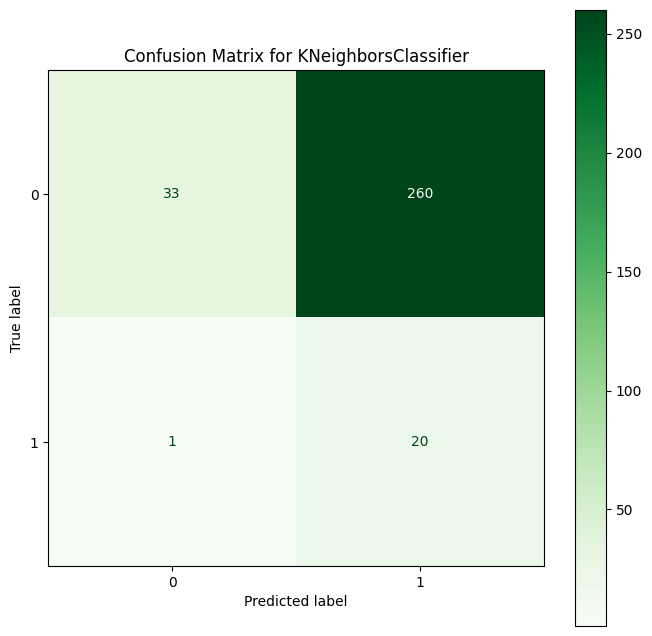

In [289]:
# Instantiate models
knn_instance = KNC()
svc_instance = SVC()
gbc_instance = GBC()
xgbc_instance = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Dictionary of model classes for comparison
model_dict = {
    'KNeighborsClassifier': knn_instance,
    'SVC': svc_instance,
    'GradientBoostingClassifier': gbc_instance,
    'XGBClassifier': xgbc_instance
}

# Feature selection methods dictionary
feature_selection_methods = {
    'PCA': PCA(n_components=120)
}

# Initialize variables for clarity
best_model_pipeline = None

# Finding and setting up the pipeline with the best model and method
for method_name, feature_selector in feature_selection_methods.items():
    if method_name == best_method:
        feature_selector_instance = feature_selector
        print(feature_selector_instance)
        break

for model_name, model_instance in model_dict.items():
    if model_name == winning_model:
        # Adjust model parameters as needed
        model_instance.set_params(**best_hp)
        print(model_instance.set_params(**best_hp))
        best_model_pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selector', feature_selector_instance),
            ('smote', SMOTE(random_state=101)),
            ('classifier', model_instance)
        ])
        break

if best_model_pipeline:
    # Fit the pipeline on the entire training set
    best_model_pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_model_pipeline.predict(X_test)



    print(classification_report(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='binary'))

    cm = confusion_matrix(y_test, y_pred, labels=model_instance.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_instance.classes_)

    fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
    disp.plot(cmap='Greens', ax=ax, colorbar=True)  # Use a colormap
    disp.ax_.set_title(f'Confusion Matrix for {model_name}')

    plt.show()
else:
    print("Best model and method combination could not be determined.")

Interpreting the results from the classification report and recall score, especially in the context of aiming for a high recall, involves understanding the trade-offs between different metrics. Let's break down what these metrics mean, focusing on a binary classification problem where we are particularly interested in minimizing false negatives (FN):

### Recall (Sensitivity)
- **Recall** is the ratio of correctly predicted positive observations to all actual positives: `TP / (TP + FN)`.
- A high recall of a about 95% in for class 1 indicates that the model is excellent at identifying the positive class and minimizing false negatives. For semiconductor manufacturing where missing a positive case has severe consequences, a high recall is desirable.

### Precision
- **Precision** is the ratio of correctly predicted positive observations to the total predicted positives: `TP / (TP + FP)`.
- Low precision for class 1 suggests that while the model is good at catching positives, it also incorrectly labels quite a few negatives as positives (high false positives).


### Interpreting These Metrics
- **High Recall, Low Precision for Class 1**: Our model is achieving the goal of minimizing false negatives for class 1, at the expense of incorrectly classifying many class 0 instances as class 1 (false positives). This is evident from the high recall and low precision for class 1.
- **Low Accuracy**: Indicates that, while you're catching most of the class 1 instances, there are a lot of errors overall. This might be acceptable depending on the cost of false positives versus false negatives in your application.

- **Trade-offs**: The results reflect a trade-off between recall and precision. Boosting recall for class 1 has led to many class 0 instances being misclassified as class 1, which might or might not be acceptable depending on your specific application's needs and the consequences of false positives versus false negatives.

### What to Consider Next

- **Cost/Benefit Analysis**: Sometimes, a detailed cost/benefit analysis can help in deciding the acceptable trade-offs for your specific application. Let's look into the cost of false postives for semiconductor manufacturing.